## Analisis Calidad de la data

In [10]:
import pyspark
from pyspark.sql.functions import *



### Creamos la sesion spark y la inicializamos

In [2]:
spark = pyspark.sql.SparkSession.builder.appName("quality").getOrCreate()

###  Carga de base de datos

In [3]:
path = "dataset.csv"
df = spark.read.csv(path,header=True,sep=',', inferSchema="True")
df.show(5)

+-----------+-----------+--------+------------+----------------+--------------------+--------------------+---------------------------+---------------------+------------------+-----------------------+-------------------+--------------------------+---------------------------+-------------------------------+-----------------------+----------------------+--------------------+--------------------+-----------------------------+------------------+------------+-----------------+--------------------+--------------------+------------------+------------------+
|disc_number|duration_ms|explicit|track_number|track_popularity|            track_id|          track_name|audio_features.danceability|audio_features.energy|audio_features.key|audio_features.loudness|audio_features.mode|audio_features.speechiness|audio_features.acousticness|audio_features.instrumentalness|audio_features.liveness|audio_features.valence|audio_features.tempo|   audio_features.id|audio_features.time_signature|         artist_id|

### Lo primero es entender la base que estamos procesando 

### Tenemos una base de albunes con sus canciones de Taylor Swift asi mismo validamos las columnas donde se encuentran variables como que tan bailable puede ser, su energia , presencia de ruido , o palabras entre otros

In [4]:
df.printSchema()

root
 |-- disc_number: integer (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- explicit: string (nullable = true)
 |-- track_number: integer (nullable = true)
 |-- track_popularity: integer (nullable = true)
 |-- track_id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- audio_features.danceability: double (nullable = true)
 |-- audio_features.energy: double (nullable = true)
 |-- audio_features.key: double (nullable = true)
 |-- audio_features.loudness: double (nullable = true)
 |-- audio_features.mode: integer (nullable = true)
 |-- audio_features.speechiness: double (nullable = true)
 |-- audio_features.acousticness: double (nullable = true)
 |-- audio_features.instrumentalness: string (nullable = true)
 |-- audio_features.liveness: double (nullable = true)
 |-- audio_features.valence: double (nullable = true)
 |-- audio_features.tempo: double (nullable = true)
 |-- audio_features.id: string (nullable = true)
 |-- audio_features.time_signatu

### Comprobamos los tipos de cada columna que esten acorde a su significado dado que esto puede afectar para un modelado cuando una columna no tenga el topo correcto

### en este caso vemos las columnas album_total_tracks y audio_features.instrumentalness: estan en un formato string , cuando deberia tener un formato integer y double respectivamente

### para el caso de audio_features.mode este debneria ser un boleano dado que toma solo valores de "0" y 1

## Valores nulos

### Como tenemos nombres de columnas con ".", reemplazamos esto por "_" para poder hacer el  conteo de los nulos por columnas y no tener conflictos en pyspark

In [73]:
df1 = df.toDF(*[c.replace('.', '_') for c in df.columns])
df1.show(3)

+-----------+-----------+--------+------------+----------------+--------------------+--------------------+---------------------------+---------------------+------------------+-----------------------+-------------------+--------------------------+---------------------------+-------------------------------+-----------------------+----------------------+--------------------+--------------------+-----------------------------+------------------+------------+-----------------+--------------------+--------------------+------------------+------------------+
|disc_number|duration_ms|explicit|track_number|track_popularity|            track_id|          track_name|audio_features_danceability|audio_features_energy|audio_features_key|audio_features_loudness|audio_features_mode|audio_features_speechiness|audio_features_acousticness|audio_features_instrumentalness|audio_features_liveness|audio_features_valence|audio_features_tempo|   audio_features_id|audio_features_time_signature|         artist_id|

In [41]:
df1.select([count(when(col(k).isNull(),k)).alias(k) for k in df1.columns ]).show()

+-----------+-----------+--------+------------+----------------+--------+----------+---------------------------+---------------------+------------------+-----------------------+-------------------+--------------------------+---------------------------+-------------------------------+-----------------------+----------------------+--------------------+-----------------+-----------------------------+---------+-----------+-----------------+--------+----------+------------------+------------------+
|disc_number|duration_ms|explicit|track_number|track_popularity|track_id|track_name|audio_features_danceability|audio_features_energy|audio_features_key|audio_features_loudness|audio_features_mode|audio_features_speechiness|audio_features_acousticness|audio_features_instrumentalness|audio_features_liveness|audio_features_valence|audio_features_tempo|audio_features_id|audio_features_time_signature|artist_id|artist_name|artist_popularity|album_id|album_name|album_release_date|album_total_tracks|
+-

### Observamos que donde tenemos mas datos faltanes es en el nombre del album

## Resumen general

In [43]:
df1.describe().show()

+-------+-------------------+------------------+--------+------------------+------------------+--------------------+--------------------+---------------------------+---------------------+------------------+-----------------------+-------------------+--------------------------+---------------------------+-------------------------------+-----------------------+----------------------+--------------------+--------------------+-----------------------------+------------------+------------+-----------------+--------------------+----------+------------------+
|summary|        disc_number|       duration_ms|explicit|      track_number|  track_popularity|            track_id|          track_name|audio_features_danceability|audio_features_energy|audio_features_key|audio_features_loudness|audio_features_mode|audio_features_speechiness|audio_features_acousticness|audio_features_instrumentalness|audio_features_liveness|audio_features_valence|audio_features_tempo|   audio_features_id|audio_features_t

### Podemos ver inconsistencia en duration_ms en donde tenemos valores minimos negativos, asi como en la variable audio_features_acousticness

## Valores duplicados

In [46]:
duplicates = df1.groupBy(*df1.columns).count().filter(col("count") > 1)
duplicates.show()
duplicates.count()

+-----------+-----------+--------+------------+----------------+--------------------+--------------------+---------------------------+---------------------+------------------+-----------------------+-------------------+--------------------------+---------------------------+-------------------------------+-----------------------+----------------------+--------------------+--------------------+-----------------------------+------------------+------------+-----------------+--------------------+--------------------+------------------+------------------+-----+
|disc_number|duration_ms|explicit|track_number|track_popularity|            track_id|          track_name|audio_features_danceability|audio_features_energy|audio_features_key|audio_features_loudness|audio_features_mode|audio_features_speechiness|audio_features_acousticness|audio_features_instrumentalness|audio_features_liveness|audio_features_valence|audio_features_tempo|   audio_features_id|audio_features_time_signature|         arti

18

### Aca podemos observar que tenemos 18 filas duplicadas , los cuales contienen los mismo registros para todas las columnas

## Alternativa grafica

In [64]:
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns

In [75]:
pandas_df = df1.toPandas()

### Mediante un boxplot podemos ver tambien que valores atipicos tienen las variables , con respecto a la media y la sd, esto nos da una mayor visual parakl  poder ir revisando la calidad de la data

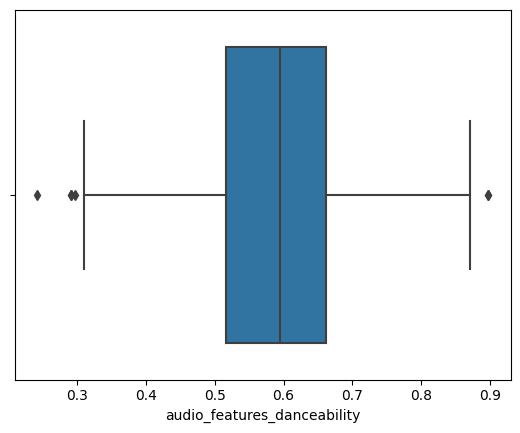

In [77]:
sns.boxplot(x='audio_features_danceability', data=pandas_df)
plt.show()

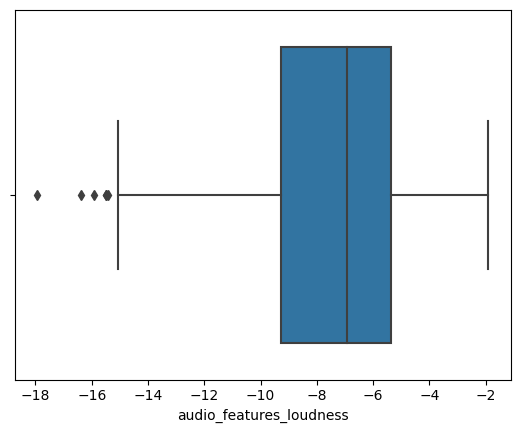

In [79]:
sns.boxplot(x='audio_features_loudness', data=pandas_df)
plt.show()

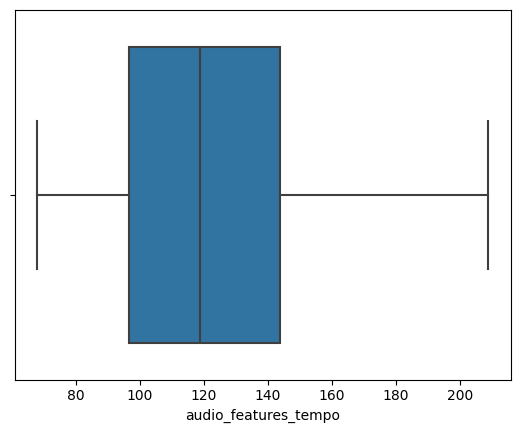

In [80]:
sns.boxplot(x='audio_features_tempo', data=pandas_df)
plt.show()